In [1]:
!nvidia-smi

Fri May  5 06:30:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B2:00.0 Off |                  Off |
| N/A   37C    P0    68W / 300W |   1649MiB / 32768MiB |     31%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('/home/fastmri2/.conda/envs/snumvi/lib/python3.8/site-packages')

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

/home/fastmri2/.conda/envs/snumvi/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/fastmri2/.conda/envs/snumvi/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.4.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "cropped/HBP/808040"

In [4]:
#!pip install openpyxl

patient_data = pd.read_excel("patient_data.xlsx", usecols="A,B")

In [5]:
import random

train_images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
train_labels = torch.nn.functional.one_hot(torch.as_tensor(patient_data["MVI"])).float()
data_list = list(zip(train_images, train_labels))
random.shuffle(data_list)
data_dicts = [{"image": image, "label": label} for image, label in data_list]
print(len(data_dicts))
print(data_dicts[0])

244
{'image': 'cropped/HBP/808040/0020491.nii.gz', 'label': tensor([0., 1.])}


In [6]:
train_files, val_files = data_dicts[:200], data_dicts[200:]
target_layer=8
set_determinism(seed=0)

In [7]:
def nii_loader(filename) :
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header 

def visualize(dataset, idx=0, target_layer=10):
    import matplotlib.pyplot as plt    

    image = dataset[idx]['image']
    label = dataset[idx]['label']
    image_data, image_affine, image_header = nii_loader(image)
    
    print('[file path]', image)
    print('[dimension]', image_data.shape)
    print('[label]', label)
    target_image = image_data[:,:,target_layer]

    plt.imshow(target_image, cmap='gray' )
    plt.show()
    return tuple(image_data.shape)

[file path] cropped/HBP/808040/0099705.nii.gz
[dimension] (80, 80, 40)
[label] tensor([0., 1.])


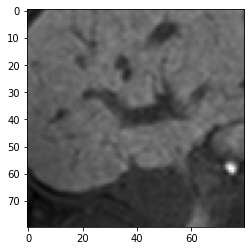

In [8]:
spatial_size = visualize( val_files, idx=1,  target_layer=target_layer)

In [9]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    AddChanneld,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandAffined,
    SpatialPadd,
    EnsureTyped,
)

In [10]:
# ScaleIntensityRanged min/max differ by organs
# for liver, min = 30 + 150/2 = 105, max = 30 - 150/2 = -45
# see more info here https://radiopaedia.org/articles/windowing-ct

from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-45, a_max=105,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        RandAffined(
            keys=["image"],
            mode=("bilinear"),
            prob=1.0, spatial_size=spatial_size,
            rotate_range=(0, 0, 0),
            scale_range=(0, 0, 0)),
        SpatialPadd(keys=["image"], spatial_size=spatial_size),
        EnsureTyped(keys=["image"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-45, a_max=105,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=spatial_size),
        EnsureTyped(keys=["image"]),
    ]
)

image shape: torch.Size([80, 80, 40]), label shape: torch.Size([])


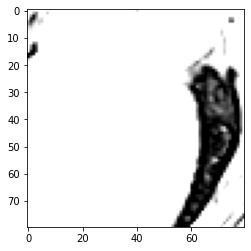

In [11]:
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.imshow(image[:, :, spatial_size[2]//2], cmap="gray")
plt.show()

In [12]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4, progress=True)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████| 44/44 [00:00<00:00, 50.85it/s]


In [13]:
from monai.networks.nets import DenseNet121

device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=3,
    in_channels=1,
    out_channels=2
).to(device)

In [14]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
max_epochs = 50
val_interval = 1
save_interval = 10
best_score = -1
best_score_epoch = -1
epoch_loss_values = []
metric_values = []
model_name = 'Densenet80'

In [15]:
%%time

import time

for epoch in range(max_epochs):
    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(f"\nepoch {epoch + 1}/{max_epochs} steps {step}/{len(train_ds) // train_loader.batch_size}, |train-loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg-loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_count = 0
        val_correct = 0.0
        
        with torch.no_grad():
            for val_data in val_loader:
                inputs, labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                outputs = model(inputs)
                val_result = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
                val_count += len(val_result)
                val_correct += val_result.sum().item()
            
            val_score = val_correct / val_count
            metric_values.append(val_score)
            print(f"|val-acc: {val_score:.4f} |old-best: {best_score:.4f} " , end="")
            
            if val_score > best_score:
                best_score = val_score
                best_score_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_best.pth".format(model_name)))
                torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_best.pth".format(model_name)))
                print("|best model saved", end="")
    
    if (epoch+1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_{:04d}.pth".format(model_name, epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_{:04d}.pth".format(model_name, epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(f"\ntrain completed, best_metric: {best_score:.4f} at epoch: {best_score_epoch} for {max_epochs} epoches")


epoch 1/50 steps 5/100, |train-loss: 0.7035
epoch 1/50 steps 10/100, |train-loss: 0.5771
epoch 1/50 steps 15/100, |train-loss: 0.6161
epoch 1/50 steps 20/100, |train-loss: 0.7639
epoch 1/50 steps 25/100, |train-loss: 0.7637
epoch 1/50 steps 30/100, |train-loss: 0.6336
epoch 1/50 steps 35/100, |train-loss: 0.6420
epoch 1/50 steps 40/100, |train-loss: 0.7810
epoch 1/50 steps 45/100, |train-loss: 0.7838
epoch 1/50 steps 50/100, |train-loss: 0.7721
epoch 1/50 steps 55/100, |train-loss: 0.6278
epoch 1/50 steps 60/100, |train-loss: 0.6041
epoch 1/50 steps 65/100, |train-loss: 0.7685
epoch 1/50 steps 70/100, |train-loss: 0.6544
epoch 1/50 steps 75/100, |train-loss: 0.5563
epoch 1/50 steps 80/100, |train-loss: 0.8119
epoch 1/50 steps 85/100, |train-loss: 0.7245
epoch 1/50 steps 90/100, |train-loss: 0.6426
epoch 1/50 steps 95/100, |train-loss: 0.6668
epoch 1/50 steps 100/100, |train-loss: 0.6538 |avg-loss: 0.7128 dur 17.6s |val-acc: 0.5000 |old-best: -1.0000 |best model saved
epoch 2/50 steps 

In [16]:
!rm -rf pymp-*

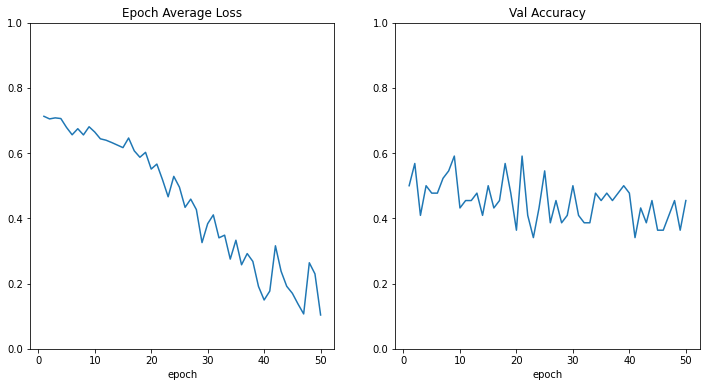

In [17]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Accuracy")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()